In [1]:
include("./trajopt/utils.jl")
include("./trajopt/dynamics.jl")
include("./funlopt/funl_dynamics.jl")
include("./funlopt/funl_utils.jl")
include("./funlopt/funl_ctcs.jl")
include("./funlopt/funl_constraint.jl")
include("./trajopt/scaling.jl")

compute_scaling (generic function with 1 method)

In [2]:
# load nominal trajectory
using JLD2, FileIO
@load "./data/nominal_traj_unicycle_0324" my_dict
xnom = my_dict["x"]
unom = my_dict["u"]
tnom = my_dict["t"];
N = size(xnom,2) - 1
dtnom = zeros(N)
for i in 1:N
    dtnom[i] = tnom[i+1]-tnom[i]
end

In [3]:
dynamics = Unicycle()
ix = dynamics.ix
iu = dynamics.iu
alpha = 0.1
dynamics.β .= [2.0,2.0]
θ0 = 1.0
DLMI = LinearDLMI(alpha,ix,iu)

LinearDLMI(0.1, 3, 2, 9, 6, 0, [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1], [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1])

In [4]:
function get_H_obs(rx,ry)
    return diagm([1/rx,1/ry])
end
c_list = []
H_list = []
c1 = [1,2]
H1 = get_H_obs(0.5,0.5)
push!(c_list,c1)
push!(H_list,H1)
c2 = [4,3]
H2 = get_H_obs(0.5,0.5)
push!(c_list,c2)
push!(H_list,H2)

vmax = 2.0
vmin = 0.0
wmax = 2.0
wmin = -2.0
list_const = [InputConstraint([1;0],vmax),
    InputConstraint([-1;0],-vmin),
    InputConstraint([0; 1],wmax),
    InputConstraint([0; -1],-wmin),
    ObstacleAvoidance(H_list[1],c_list[1]),
    ObstacleAvoidance(H_list[2],c_list[2])
    ]

6-element Vector{FunnelConstraint}:
 InputConstraint([1, 0], 2.0)
 InputConstraint([-1, 0], -0.0)
 InputConstraint([0, 1], 2.0)
 InputConstraint([0, -1], 2.0)
 ObstacleAvoidance([2.0 0.0; 0.0 2.0], [1, 2])
 ObstacleAvoidance([2.0 0.0; 0.0 2.0], [4, 3])

In [5]:
Qnom = zeros(ix,ix,N+1)
Ynom = zeros(iu,ix,N+1)
Znom = zeros(ix,ix,N+1);
Qini = diagm([0.08,0.08,0.06])
Qf = diagm([0.08,0.08,0.06])

3×3 Matrix{Float64}:
 0.08  0.0   0.0
 0.0   0.08  0.0
 0.0   0.0   0.06

In [6]:
xmin = [0;0;0];
xmax = [5;5;pi];
umin = [0;0];
umax = [vmax;wmax];
scaler = Scaling(xmin, xmax, umin, umax, tnom[end],0,0)
scaler.s_ctcs = 1

1

In [7]:
include("./funlopt/funl_synthesis.jl")

run (generic function with 2 methods)

In [8]:
max_iter = 1;
w_funl = 1.0;
w_vc = 0.0;
w_tr::Float64 = 0.0
tol_vc = 1e-8;
tol_tr = 1e-6;
tol_dyn = 1e-1;
verbosity = true;

In [9]:
fs = FunnelSynthesis(N,max_iter,dynamics,DLMI,list_const,scaler,
    w_funl,w_vc,w_tr,tol_tr,tol_vc,tol_dyn,
    verbosity,
    flag_type="Lsmooth",
    # funl_ctcs=CTCS
    );

Lsmooth funnel and CTCS is ignored


In [10]:
run(fs,Qnom,Ynom,Znom,Qini,Qf,xnom,unom,dtnom,"Mosek",θ0)

+--------------------------------------------------------------------------------------------------+
|                                   ..:: Penalized Trust Region ::..                               |
+-------+------------+-----------+-----------+-----------+---------+---------+----------+----------+
| iter. |    cost    |    tof    |   funl    |   rate    |  param  | log(vc) | log(tr)  | log(dyn) |
+-------+------------+-----------+-----------+-----------+---------+---------+----------+----------+
|1      |2.00        |-1.000    |1.995      |-1.000     |-1.000    |-Inf     | -0.9     |-7.6e+00   |


In [11]:
tprop,xprop,uprop = fs.solution.tprop,fs.solution.xprop,fs.solution.uprop
Qprop,Yprop = fs.solution.Qprop,fs.solution.Yprop
K = zeros(iu,ix,N+1)
for i in 1:N+1
    K[:,:,i] = fs.solution.Y[:,:,i] * inv(fs.solution.Q[:,:,i])
end
max_iter = 1;

([0.5890286742476313 -0.09306285100508786 0.024090046802397253; -0.09306285100508786 0.581272229002407 -0.1197973682404144; 0.024090046802397253 -0.11979736824041438 0.43226247503849663;;; 0.5894070853592136 -0.09307353605297025 0.024219402189584762; -0.09307353605297025 0.5819074226415064 -0.1199462090382708; 0.024219402189584762 -0.11994620903827079 0.43078403810102983;;; 0.590197105777114 -0.09309619711344747 0.024490548888480717; -0.09309619711344747 0.5832317475748687 -0.12025191588807478; 0.024490548888480717 -0.12025191588807477 0.4276848224880058;;; … ;;; 0.07967728653660547 0.0007594191759044829 -0.008063497125565115; 0.0007594191759044829 0.07928952832774304 -0.006299056590921575; -0.008063497125565115 -0.006299056590921578 0.017111595046596102;;; 0.07947532610900618 0.0003942482501720347 -0.0055704681919373595; 0.0003942482501720347 0.07961193234751131 -0.0027205481657992608; -0.0055704681919373595 -0.0027205481657992642 0.016609695882041926;;; 0.07935751799256975 0.00017734

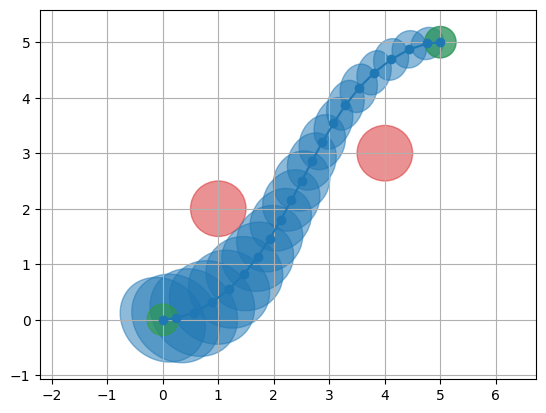

In [12]:
radius_Q,angle_Q = get_radius_angle_Ellipse2D(fs.solution.Q)
radius_Qi,angle_Qi = get_radius_angle_Ellipse2D(fs.solution.Qi)
radius_Qf,angle_Qf = get_radius_angle_Ellipse2D(fs.solution.Qf)

plt.figure()
ax = plt.subplot(111)
for (ce, H) in zip(c_list, H_list)
    rx = 1 / H[1, 1]  # Adjusted indexing for Julia (1-based indexing)
    ry = 1 / H[2, 2]  # Adjusted indexing for Julia
    circle1 = matplotlib[:patches][:Ellipse]((ce[1], ce[2]), width=rx*2, height=ry*2, color="tab:red", alpha=0.5, fill=true)
    ax[:add_patch](circle1)  # Using add_patch method to add the ellipse to the plot
end
for i in 1:N+1
    x_ = xnom[:,i]
    radius = radius_Q[i]
    angle = angle_Q[i]
    ell = matplotlib[:patches][:Ellipse]((x_[1],x_[2]),radius[1]*2,radius[2]*2,angle=rad2deg(angle),color="tab:blue",alpha=0.5,fill=true)
    ax.add_patch(ell)
end
for (x_,radius,angle) in zip([xnom[:,1],xnom[:,end]],[radius_Qi[1],radius_Qf[1]],[angle_Qi[1],angle_Qf[1]])
    ell = matplotlib[:patches][:Ellipse]((x_[1],x_[2]),radius[1]*2,radius[2]*2,angle=rad2deg(angle),color="tab:green",alpha=0.5,fill=true)
    ax.add_patch(ell)
end

ax.plot(xnom[1,:],xnom[2,:],"o-",color="tab:blue")
# ax.plot(ptr.solution.xprop[1,:],ptr.solution.xprop[2,:],"-",color="tab:blue")
ax.grid(true)
ax[:axis]("equal")
gcf()

## Check eigenvalue of Q

In [13]:
min_lam_qprop = zeros(size(Qprop,3))
for i in 1:size(Qprop,3)
    eigvals = eigen(Qprop[:,:,i]).values
    min_lam_qprop[i] = eigvals[1]
end
min_lam_q = zeros(size(fs.solution.Q,3))
for i in 1:size(fs.solution.Q,3)
    eigvals = eigen(fs.solution.Q[:,:,i]).values
    min_lam_q[i] = eigvals[1]
end

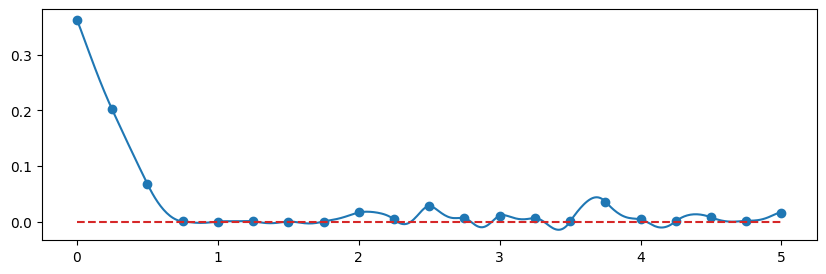

In [14]:
plt.figure(figsize=(10,3))
plt.plot(tnom,min_lam_q,"o",color="tab:blue")
plt.plot(tprop,min_lam_qprop,"-",color="tab:blue")
plt.plot(tprop,tprop*0,"--",color="tab:red")
# plt.xlim([tnom[19],tnom[20]])
# plt.ylim([-1e-3,1e-3])
gcf()

In [15]:
minimum(min_lam_qprop)

-0.014800456634006297

# Funnel refinement

In [65]:
include("./funlopt/funl_refinement.jl")
include("./funlopt/funl_dynamics.jl")

diff (generic function with 8 methods)

In [66]:
funl_refine = LinearQZ(alpha,ix,iu)

LinearQZ(0.1, 3, 2, 9, 6, [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1], [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1])

In [67]:
fr = FunnelRefinement(N,max_iter,dynamics,funl_refine,list_const,scaler,
    w_funl,w_vc,w_tr,tol_tr,tol_vc,tol_dyn,
    verbosity,
    flag_type="Lsmooth",
    );

Lsmooth funnel and CTCS is ignored


In [68]:
run(fr,fs.solution.Q,K,fs.solution.Z,Qini,Qf,xnom,unom,dtnom,"Mosek",θ0)

Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 244             
  Affine conic cons.     : 196 (2333 rows)
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 221             
  Matrix variables       : 21 (scalarized: 126)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 63
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - dual attempts          : 0       

In [69]:
tprop,xprop,uprop = fr.solution.tprop,fr.solution.xprop,fr.solution.uprop
Qprop,Kprop = fr.solution.Qprop,fr.solution.Kprop

([0.2526037266442186 -0.024833265928631654 -0.003919120033567141; -0.024833265928631654 0.22907029914653732 -0.07396212517516247; -0.003919120033567141 -0.07396212517516247 0.11019159352905494;;; 0.2382364233730162 0.0027568794407426536 -0.00966544243226099; 0.002756879440742658 0.2844931902581104 -0.3045453423923659; -0.00966544243226099 -0.30454534239236597 0.11937219841148651;;; 0.20306676939526835 0.07032161029063623 -0.02373613542068114; 0.07032161029063624 0.4202181739222745 -0.8691721931578519; -0.02373613542068114 -0.8691721931578519 0.14183932394280957;;; … ;;; -104.19072899775418 523.8854001390731 55.306792400214576; 523.8854001390731 1455.8678160396983 25.91039891258178; 55.30679240021459 25.910398912581663 24.79420365321248;;; -104.33112433051008 522.9771258409226 56.01191214595058; 522.9771258409226 1456.4635257412936 31.13600843585671; 56.011912145950596 31.136008435856592 25.849469021587595;;; -104.39952130438266 522.5201768986592 56.362639866270115; 522.5201768986592 14

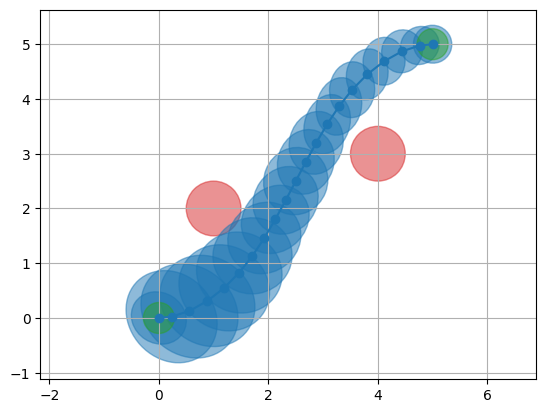

In [70]:
radius_Q,angle_Q = get_radius_angle_Ellipse2D(fr.solution.Q)
radius_Qi,angle_Qi = get_radius_angle_Ellipse2D(fr.solution.Qi)
radius_Qf,angle_Qf = get_radius_angle_Ellipse2D(fr.solution.Qf)

plt.figure()
ax = plt.subplot(111)
for (ce, H) in zip(c_list, H_list)
    rx = 1 / H[1, 1]  # Adjusted indexing for Julia (1-based indexing)
    ry = 1 / H[2, 2]  # Adjusted indexing for Julia
    circle1 = matplotlib[:patches][:Ellipse]((ce[1], ce[2]), width=rx*2, height=ry*2, color="tab:red", alpha=0.5, fill=true)
    ax[:add_patch](circle1)  # Using add_patch method to add the ellipse to the plot
end
for i in 1:N+1
    x_ = xnom[:,i]
    radius = radius_Q[i]
    angle = angle_Q[i]
    ell = matplotlib[:patches][:Ellipse]((x_[1],x_[2]),radius[1]*2,radius[2]*2,angle=rad2deg(angle),color="tab:blue",alpha=0.5,fill=true)
    ax.add_patch(ell)
end
for (x_,radius,angle) in zip([xnom[:,1],xnom[:,end]],[radius_Qi[1],radius_Qf[1]],[angle_Qi[1],angle_Qf[1]])
    ell = matplotlib[:patches][:Ellipse]((x_[1],x_[2]),radius[1]*2,radius[2]*2,angle=rad2deg(angle),color="tab:green",alpha=0.5,fill=true)
    ax.add_patch(ell)
end

ax.plot(xnom[1,:],xnom[2,:],"o-",color="tab:blue")
# ax.plot(ptr.solution.xprop[1,:],ptr.solution.xprop[2,:],"-",color="tab:blue")
ax.grid(true)
ax[:axis]("equal")
gcf()

In [52]:
min_lam_qprop = zeros(size(Qprop,3))
for i in 1:size(Qprop,3)
    eigvals = eigen(Qprop[:,:,i]).values
    min_lam_qprop[i] = eigvals[1]
end
min_lam_q = zeros(size(fr.solution.Q,3))
for i in 1:size(fr.solution.Q,3)
    eigvals = eigen(fr.solution.Q[:,:,i]).values
    min_lam_q[i] = eigvals[1]
end

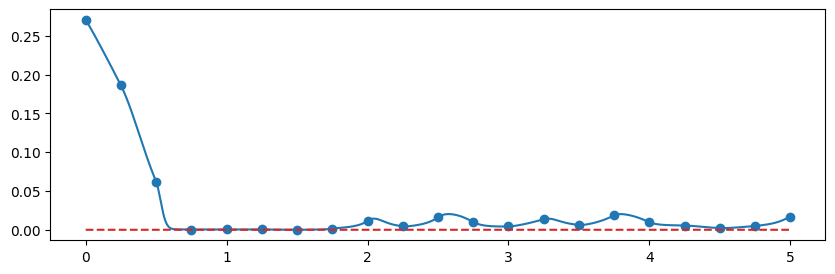

In [53]:
plt.figure(figsize=(10,3))
plt.plot(tnom,min_lam_q,"o",color="tab:blue")
plt.plot(tprop,min_lam_qprop,"-",color="tab:blue")
plt.plot(tprop,tprop*0,"--",color="tab:red")
# plt.xlim([tnom[19],tnom[20]])
# plt.ylim([-1e-3,1e-3])
gcf()

In [54]:
minimum(min_lam_qprop)

3.0160556141245465e-5

In [ ]:
function project_onto_input(Q,K) 
    R = []
    for i in 1:size(Q,3)
        push!(R,K[:,:,i]*Q[:,:,i]*K[:,:,i]')
    end
    projected_input_funl = []
    for j in 1:iu
        a = zeros(iu)
        a[j] = 1
        each_funl = []
        for i in 1:length(R)
            push!(each_funl,sqrt(a'*R[i]*a))
        end
        push!(projected_input_funl,each_funl)
    end
    return projected_input_funl
end

In [ ]:
input_proj_funl_prop = project_onto_input(Qprop,Kprop)
input_proj_funl_nom = project_onto_input(fr.solution.Q,fr.solution.K)

In [ ]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(tnom,unom[1,:],"--",color="black")
plt.plot(tnom,unom[1,:]+input_proj_funl_nom[1],"o",color="tab:blue")
plt.plot(tnom,unom[1,:]-input_proj_funl_nom[1],"o",color="tab:blue")
plt.plot(tprop,uprop[1,:]+input_proj_funl_prop[1],"-",color="tab:blue")
plt.plot(tprop,uprop[1,:]-input_proj_funl_prop[1],"-",color="tab:blue")
plt.plot(tnom,tnom*0 .+ vmax,"--",color="tab:red")
plt.plot(tnom,tnom*0 .+ vmin,"--",color="tab:red")
# plt.ylim([-0.1,2.1])
plt.grid(true)
plt.subplot(122)
plt.plot(tnom,unom[2,:],"--",color="black")
plt.plot(tnom,unom[2,:]+input_proj_funl_nom[2],"o",color="tab:blue")
plt.plot(tnom,unom[2,:]-input_proj_funl_nom[2],"o",color="tab:blue")
plt.plot(tprop,uprop[2,:]+input_proj_funl_prop[2],"-",color="tab:blue")
plt.plot(tprop,uprop[2,:]-input_proj_funl_prop[2],"-",color="tab:blue")
plt.plot(tnom,tnom*0 .+ wmax,"--",color="tab:red")
plt.plot(tnom,tnom*0 .+ wmin,"--",color="tab:red")
# plt.ylim([-2.5,2.5])
plt.grid(true)
gcf()

In [ ]:
# my_dict = Dict("x" => xnom, "u" => unom, "t" => tnom,
#      "Q" => fs.solution.Q, "Y" => fs.solution.Y, "Z" => fs.solution.Z)
# using JLD2, FileIO

# @save "./data/xuQYZ_unicycle_0328" my_dict